In [1]:
import pandas as pd
import numpy as np
import itertools as it

import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import matplotlib.ticker as mtick

from scipy.stats import entropy

plt.rc('axes', axisbelow=True)
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'

%matplotlib inline

In [2]:
def get_ci(df, col, gb_col='date', percentile='95'):
    if percentile == '99':
        cival = 2.576
    if percentile == '95':
        cival = 1.96
    if percentile == '90':
        cival = 1.645
    if percentile == '80':
        cival = 1.282

    df_stats = df.groupby(gb_col)[col].agg([np.nanmean,'count',np.nanstd])
    ci95_hi = []
    ci95_lo = []
    for i in df_stats.index:
        m, c, s = df_stats.loc[i]
        ci95_hi.append(m + cival*s/np.sqrt(c))
        ci95_lo.append(m - cival*s/np.sqrt(c))
    df_stats['ci95_hi'] = ci95_hi
    df_stats['ci95_lo'] = ci95_lo

    return df_stats.reset_index()


all_state_names = {'ak': 'Alaska', 'al': 'Alabama', 'ar': 'Arkansas',
                   'as': 'American Samoa',  'az': 'Arizona',
                   'ca': 'California', 'co': 'Colorado',
                   'ct': 'Connecticut', 'dc': 'District of Columbia',
                   'de': 'Delaware', 'fl': 'Florida', 'ga': 'Georgia',
                   'gu': 'Guam', 'hi': 'Hawaii', 'ia': 'Iowa',
                   'id': 'Idaho', 'il': 'Illinois', 'in': 'Indiana',
                   'ks': 'Kansas', 'ky': 'Kentucky', 'la': 'Louisiana',
                   'ma': 'Massachusetts', 'md': 'Maryland', 'me': 'Maine',
                   'mi': 'Michigan', 'mn': 'Minnesota', 'mo': 'Missouri',
                   'mp': 'Northern Mariana Islands', 'ms': 'Mississippi',
                   'mt': 'Montana', 'nc': 'North Carolina',
                   'nd': 'North Dakota', 'ne': 'Nebraska',
                   'nh': 'New Hampshire', 'nj': 'New Jersey',
                   'nm': 'New Mexico', 'nv': 'Nevada', 'ny': 'New York',
                   'oh': 'Ohio', 'ok': 'Oklahoma', 'or': 'Oregon',
                   'pa': 'Pennsylvania', 'pr': 'Puerto Rico',
                   'ri': 'Rhode Island', 'sc': 'South Carolina',
                   'sd': 'South Dakota', 'tn': 'Tennessee', 'tx': 'Texas',
                   'ut': 'Utah', 'va': 'Virginia',
                   'vi': 'Virgin Islands', 'vt': 'Vermont',
                   'wa': 'Washington', 'wi': 'Wisconsin',
                   'wv': 'West Virginia', 'wy': 'Wyoming'}

all_state_ids = {'01': 'al', '02': 'ak', '04': 'az', '05': 'ar',
                 '06': 'ca', '08': 'co', '09': 'ct', '10': 'de',
                 '11': 'dc', '12': 'fl', '13': 'ga', '15': 'hi',
                 '16': 'id', '17': 'il', '18': 'in', '19': 'ia',
                 '20': 'ks', '21': 'ky', '22': 'la', '23': 'me',
                 '24': 'md', '25': 'ma', '26': 'mi', '27': 'mn',
                 '28': 'ms', '29': 'mo', '30': 'mt', '31': 'ne',
                 '32': 'nv', '33': 'nh', '34': 'nj', '35': 'nm',
                 '36': 'ny', '37': 'nc', '38': 'nd', '39': 'oh',
                 '40': 'ok', '41': 'or', '42': 'pa', '44': 'ri',
                 '45': 'sc', '46': 'sd', '47': 'tn', '48': 'tx',
                 '49': 'ut', '50': 'vt', '51': 'va', '53': 'wa',
                 '54': 'wv', '55': 'wi', '56': 'wy', "60": 'as',
                 "66": 'gu', "72": 'pr', '78': 'vi', '69': 'mp'}

all_ids_state = {j:i for i,j in all_state_ids.items()}

month_dict = {'01':'Jan','02':'Feb','03':'Mar','04':'Apr','05':'May','06':'Jun',
              '07':'Jul','08':'Aug','09':'Sep','10':'Oct','11':'Nov','12':'Dec'}

today = str(dt.datetime.date(dt.datetime.now()))

# make DATE_DF, a simple dataframe with dates, weekdays, and weeknums
weekday_mapping = {0:'Monday',1:'Tuesday',2:'Wednesday',
                   3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'}

alldates = pd.date_range(start='2020-01-01', end='2021-12-31').tolist()
datelist = [str(i.date()) for i in alldates]
weekdays = [weekday_mapping[i.date().weekday()] for i in alldates]
weeklist = [i//7 for i in range(len(alldates))]
DATE_DF = pd.DataFrame({'date':datelist,'day':weekdays,'week':weeklist})
DATE_DF = DATE_DF.loc[DATE_DF['date']<=today].copy()
DATERANGE = DATE_DF['date'].tolist()
date_dict = dict(zip(DATERANGE,list(range(len(DATERANGE)))))

In [3]:
fs = 9
lw = 2

In [4]:
ihe_df    = pd.read_csv('../data/campus_covid_fall2020_full.csv', dtype={'ipeds_id':str, 'fips':str})
ipeds_df  = pd.read_csv('../data/campus_covid_ipeds.csv',         dtype={'ipeds_id':str, 'fips':str})
status_df = pd.read_csv('../data/campus_covid_status.csv',        dtype={'ipeds_id':str, 'fips':str})
census_df = pd.read_csv('../data/campus_covid_census.csv',        dtype={'fips':str})
jhu_df    = pd.read_csv('../data/campus_covid_jhu_county.csv.gz', dtype={'fips':str})

In [5]:
summary_df = status_df.groupby(['fips','status_merge']
                               ).agg({'ihe_fulltime_population':'sum'}).reset_index()
summary_df = summary_df.merge(jhu_df[['fips','county_population']].drop_duplicates(),
                              how='left', on='fips')
summary_df['enrollment_fulltime'] = summary_df['ihe_fulltime_population']
summary_df['total_pop'] = summary_df['county_population']
summary_df['frac_pop_enrollment_fulltime'] = summary_df['enrollment_fulltime']/summary_df['total_pop']

summary_df['fraction_status'] = summary_df['frac_pop_enrollment_fulltime']
summary_df['status'] = summary_df['status_merge']

summary_df.head()

,fips,status_merge,ihe_fulltime_population,county_population,enrollment_fulltime,total_pop,frac_pop_enrollment_fulltime,fraction_status,status
0,01003,Primarily Online,3854,223234,3854,223234,0.017264,0.017264,Primarily Online
1,01015,Primarily Online,6738,113605,6738,113605,0.059311,0.059311,Primarily Online
2,01031,Primarily Online,1039,52342,1039,52342,0.019850,0.019850,Primarily Online
3,01033,Hybrid,1654,55241,1654,55241,0.029942,0.029942,Hybrid
4,01035,Primarily Online,209,12067,209,12067,0.017320,0.017320,Primarily Online


In [6]:
gender_cols = ['male_pop','female_pop']

age_cols = ['age_00_to_04', 'age_05_to_09', 'age_10_to_14',
            'age_15_to_19', 'age_20_to_24', 'age_25_to_29', 'age_30_to_34',
            'age_35_to_39', 'age_40_to_44', 'age_45_to_49', 'age_50_to_54',
            'age_55_to_59', 'age_60_to_64', 'age_65_to_69', 'age_70_to_74',
            'age_75_to_79', 'age_80_to_84', 'age_85_and_over']

race_cols = ['white_pop', 'black_pop', 'asian_pop', 'hispanic_pop',
             'amerindian_pop', 'other_race_pop', 'two_or_more_races_pop',
             'not_hispanic_pop']

income_cols = ['income_less_10000', 'income_10000_14999', 'income_15000_19999',
               'income_20000_24999', 'income_25000_29999', 'income_30000_34999',
               'income_35000_39999', 'income_40000_44999', 'income_45000_49999',
               'income_50000_59999', 'income_60000_74999', 'income_75000_99999',
               'income_100000_124999', 'income_125000_149999',
               'income_150000_199999', 'income_200000_or_more']

# Goal: span a number of threshold values and find the average minimum value

In [7]:
thrsh = np.logspace(-3,-1.302, 200)

ttt = {"thr":[],"n_inp":[],"n_onl":[],'ent_income':[],'ent_race':[],
       'ent_pop':[],'ent_age':[],'ent_urc':[]}

for pt in thrsh:
    inpf = summary_df.loc[(summary_df['fraction_status']>pt)&\
                                    (summary_df['status']=='Primarily In Person')]['fips'].values
    onpf = summary_df.loc[(summary_df['fraction_status']>pt)&\
                                 (summary_df['status']=='Primarily Online')]['fips'].values
    inpf = [i for i in inpf if i not in onpf]

    ttt['thr'].append(pt)
    ttt['n_inp'].append(len(inpf))
    ttt['n_onl'].append(len(onpf))

    inp_census_p = census_df.loc[census_df['fips'].isin(inpf)].copy()
    inp_census_p['status'] = 'primarily in person'
    onl_census_p = census_df.loc[census_df['fips'].isin(onpf)].copy()
    onl_census_p['status'] = 'primarily online'
    comp_cen = pd.concat([inp_census_p, onl_census_p]).reset_index().iloc[:,1:]
    for i in gender_cols+income_cols+race_cols+age_cols:
        comp_cen['frac_'+i] = comp_cen[i] / comp_cen['total_pop']

    ou0 = []
    ou1 = []
    for i in range(len(income_cols)):
        tmp = get_ci(comp_cen, ["frac_"+i for i in age_cols][i], 'status', percentile='99')
        ou0.append(tmp['nanmean'][0])
        ou1.append(tmp['nanmean'][1])
    ou0 = np.array(ou0)
    ou1 = np.array(ou1)
    inc_ent_i = 0.5*entropy(ou0,(ou0+ou1)/2) + 0.5*entropy(ou1,(ou0+ou1)/2)
    ttt['ent_income'].append(inc_ent_i)

    ou0 = []
    ou1 = []
    for i in range(len(age_cols)):
        tmp = get_ci(comp_cen, ["frac_"+i for i in age_cols][i], 'status', percentile='99')
        ou0.append(tmp['nanmean'][0])
        ou1.append(tmp['nanmean'][1])
    ou0 = np.array(ou0)
    ou1 = np.array(ou1)
    age_ent_i = 0.5*entropy(ou0,(ou0+ou1)/2) + 0.5*entropy(ou1,(ou0+ou1)/2)
    ttt['ent_age'].append(age_ent_i)
    
    ou0 = []
    ou1 = []
    for i in range(len(race_cols)):
        tmp = get_ci(comp_cen, ["frac_"+i for i in age_cols][i], 'status', percentile='99')
        ou0.append(tmp['nanmean'][0])
        ou1.append(tmp['nanmean'][1])
    ou0 = np.array(ou0)
    ou1 = np.array(ou1)
    rac_ent_i = 0.5*entropy(ou0,(ou0+ou1)/2) + 0.5*entropy(ou1,(ou0+ou1)/2)
    ttt['ent_race'].append(rac_ent_i)
        
    urb_g = comp_cen.groupby(['urban_rural_code','status']).agg({"fips":'count'}).reset_index()
    t = urb_g.loc[urb_g['status']=='primarily in person'].copy()
    for uu in [1,2,3,4,5,6]:
        if uu not in t['urban_rural_code'].values:
            adon = pd.DataFrame({"status":[t['status'].values[0]],
                          'urban_rural_code':[float(uu)],'fips':[0]})
            t = pd.concat([t,adon])
    t = t.sort_values('urban_rural_code').reset_index().iloc[:,1:]
    ou0 = t['fips'].values/sum(t['fips'].values)
    
    t = urb_g.loc[urb_g['status']=='primarily online'].copy()
    for uu in [1,2,3,4,5,6]:
        if uu not in t['urban_rural_code'].values:
            adon = pd.DataFrame({"status":[t['status'].values[0]],
                          'urban_rural_code':[float(uu)],'fips':[0]})
            t = pd.concat([t,adon])
    t = t.sort_values('urban_rural_code').reset_index().iloc[:,1:]
    ou1 = t['fips'].values/sum(t['fips'].values)

    urc_ent_i = 0.5*entropy(ou0,(ou0+ou1)/2) + 0.5*entropy(ou1,(ou0+ou1)/2)
    ttt['ent_urc'].append(urc_ent_i)

    
    nbins = 6
    _, bins = np.histogram(np.log10(comp_cen['total_pop']), bins=nbins)

    ou0,_ = np.histogram(np.log10(comp_cen.loc[comp_cen['status']=='primarily online']['total_pop']),
                        bins=bins)
    ou1,_ = np.histogram(np.log10(comp_cen.loc[comp_cen['status']=='primarily in person']['total_pop']),
                        bins=bins)
    ou0 = ou0 / sum(ou0)
    ou1 = ou1 / sum(ou1)    
    pop_ent_i = 0.5*entropy(ou0,(ou0+ou1)/2) + 0.5*entropy(ou1,(ou0+ou1)/2)
    ttt['ent_pop'].append(pop_ent_i)

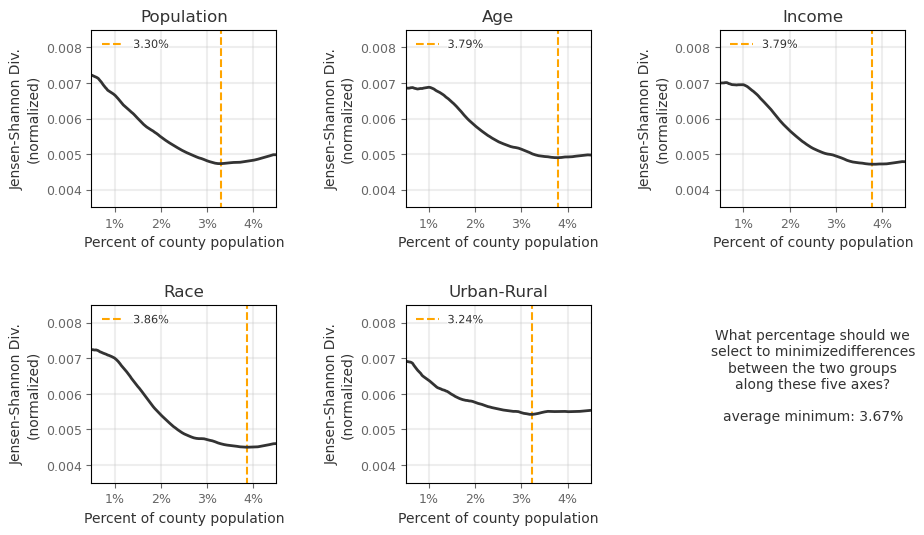

In [8]:
wid = 42
w = 3.5; h = 3.0
ncols = 3; nrows = 2
tups = list(it.product(range(nrows), range(ncols)))
fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*w,nrows*h), dpi=100)
plt.subplots_adjust(wspace=0.7,hspace=0.55)

avgs = []
titles = ['Population', 'Age', 'Income','Race','Urban-Rural']
for vi, dat_col in enumerate(['pop','age','income','race','urc']):
    dat_col = "ent_"+dat_col
    a = tups[vi]
    
    xvals = np.array(ttt['thr'])
    yvals = pd.Series(ttt[dat_col]).rolling(window=wid).mean().values
    yvals = yvals / np.nansum(yvals)
    minval = xvals[np.argmin(yvals[wid-1:-1])+(wid-1)]
    ax[a].plot(xvals, yvals, color='.2', lw=lw)
    if dat_col == 'ent_urc':
        ax[a].vlines(minval, 0, 1, linestyle='--', label='%.2f%%'%((minval)*100),
                 color='orange')
        avgs.append(minval)
    else:
        ax[a].vlines(minval, 0, 1, linestyle='--', label='%.2f%%'%(minval*100),
                 color='orange')
        avgs.append(minval)

    ax[a].set_ylim(0, np.nanmax(yvals))
    if dat_col == 'ent_urc':
        dat_col = 'ent_urban-rural'
    ax[a].set_title(titles[vi],color='.2')
    
    ax[a].set_ylabel('Jensen-Shannon Div.\n(normalized)',color='.2')


for ai,a in enumerate(fig.axes):
    if ai < 5:
        l = a.legend(fontsize=fs*0.9, loc=2, framealpha=0)
        for text in l.get_texts():
            text.set_color('.2')
            text.set_path_effects([path_effects.Stroke(linewidth=1.5,foreground='w'),
                                   path_effects.Normal()])

        a.set_ylim(0.0035, 0.0085)
        a.set_xlim(0.005, 0.045)
        a.xaxis.set_major_formatter(mtick.PercentFormatter(1.0,decimals=0))
        a.tick_params(labelcolor='.4', color='.4',labelsize=fs)
        a.grid(linewidth=1.5, color='.75', alpha=0.25)
        a.set_xlabel('Percent of county population', color='.2')

    else:
        question = 'What percentage should we\nselect to minimize'+\
                    'differences\nbetween the two groups\n'+\
                    'along these five axes?'
        a.text(0.5,0.6,question+'\n\naverage minimum: 3.67%',transform=a.transAxes,
               va='center',ha='center',color='.2')
        a.set_ylim(0,1)
        a.set_axis_off()


# plt.savefig('../figs/pngs/JSD_span.png', dpi=300, bbox_inches='tight')
# plt.savefig('../figs/pdfs/JSD_span.pdf', bbox_inches='tight')

plt.show()

# Now that we have the percent threshold, how do the groups compare?

In [9]:
percent_thresh = 0.036701726024525115

fips_inperson = summary_df.loc[(summary_df['frac_pop_enrollment_fulltime']>percent_thresh)&\
                               (summary_df['status_merge']=='Primarily In Person')]['fips'].unique()
print(len(fips_inperson))

fips_online = summary_df.loc[(summary_df['frac_pop_enrollment_fulltime']>percent_thresh)&\
                             (summary_df['status_merge']=='Primarily Online')]['fips'].values
fips_online = [i for i in fips_online if i not in fips_inperson]
print(len(fips_online))

college_county_fips = list(fips_online) + list(fips_inperson)

234
221


In [10]:
census_online = census_df.loc[census_df['fips'].isin(fips_online)].copy()
census_inperson = census_df.loc[census_df['fips'].isin(fips_inperson)].copy()

census_online_tmp = census_online.copy()
census_inperson_tmp = census_inperson.copy()
for i in ['age_00_to_04', 'age_05_to_09', 'age_10_to_14',
          'age_15_to_19', 'age_20_to_24', 'age_25_to_29', 'age_30_to_34',
          'age_35_to_39', 'age_40_to_44', 'age_45_to_49', 'age_50_to_54',
          'age_55_to_59', 'age_60_to_64', 'age_65_to_69', 'age_70_to_74',
          'age_75_to_79', 'age_80_to_84', 'age_85_and_over']:
    census_online_tmp[i] = census_online_tmp[i] / census_online_tmp['total_pop']
    census_inperson_tmp[i] = census_inperson_tmp[i] / census_inperson_tmp['total_pop']
    
    
census_inperson_tmp['group'] = 'in person'
census_online_tmp['group'] = 'online'

census_age_tmp = pd.concat([census_inperson_tmp, census_online_tmp]).reset_index().iloc[:,1:]

dfout = []
for i in ['age_00_to_04', 'age_05_to_09', 'age_10_to_14',
          'age_15_to_19', 'age_20_to_24', 'age_25_to_29', 'age_30_to_34',
          'age_35_to_39', 'age_40_to_44', 'age_45_to_49', 'age_50_to_54',
          'age_55_to_59', 'age_60_to_64', 'age_65_to_69', 'age_70_to_74',
          'age_75_to_79', 'age_80_to_84', 'age_85_and_over']:
    dfi = get_ci(census_age_tmp, i, 'group', percentile='99')
    dfi['age_group'] = i
    dfout.append(dfi)
    
tmp_age_df = pd.concat(dfout).reset_index().iloc[:,1:]

In [11]:
census_online = census_df.loc[census_df['fips'].isin(fips_online)].copy()
census_inperson = census_df.loc[census_df['fips'].isin(fips_inperson)].copy()

census_online_tmp = census_online.copy()
census_inperson_tmp = census_inperson.copy()
for i in [#'male_pop', 'female_pop', 
          'white_pop', 'black_pop', 'asian_pop', 'hispanic_pop',
          'amerindian_pop', 'other_race_pop', 'two_or_more_races_pop']:
    census_online_tmp[i] = census_online_tmp[i] / census_online_tmp['total_pop']
    census_inperson_tmp[i] = census_inperson_tmp[i] / census_inperson_tmp['total_pop']

census_inperson_tmp['group'] = 'in person'
census_online_tmp['group'] = 'online'

census_race_tmp = pd.concat([census_inperson_tmp, census_online_tmp]).reset_index().iloc[:,1:]

dfout = []
for i in [#'male_pop', 'female_pop', 
          'white_pop', 'black_pop', 'asian_pop', 'hispanic_pop',
          'amerindian_pop', 'other_race_pop', 'two_or_more_races_pop']:
    dfi = get_ci(census_race_tmp, i, 'group', percentile='99')
    dfi['race'] = i
    dfout.append(dfi)
    
tmp_race_df = pd.concat(dfout).reset_index().iloc[:,1:]

In [12]:
census_online = census_df.loc[census_df['fips'].isin(fips_online)].copy()
census_inperson = census_df.loc[census_df['fips'].isin(fips_inperson)].copy()

census_online_tmp = census_online.copy()
census_inperson_tmp = census_inperson.copy()
for i in ['income_less_10000', 'income_10000_14999', 'income_15000_19999',
          'income_20000_24999', 'income_25000_29999', 'income_30000_34999',
          'income_35000_39999', 'income_40000_44999', 'income_45000_49999',
          'income_50000_59999', 'income_60000_74999', 'income_75000_99999',
          'income_100000_124999', 'income_125000_149999', 'income_150000_199999',
          'income_200000_or_more']:
    census_online_tmp[i] = census_online_tmp[i] / census_online_tmp['total_pop']
    census_inperson_tmp[i] = census_inperson_tmp[i] / census_inperson_tmp['total_pop']

census_inperson_tmp['group'] = 'in person'
census_online_tmp['group'] = 'online'

census_inc_tmp = pd.concat([census_inperson_tmp, census_online_tmp]).reset_index().iloc[:,1:]

dfout = []
for i in ['income_less_10000', 'income_10000_14999', 'income_15000_19999',
          'income_20000_24999', 'income_25000_29999', 'income_30000_34999',
          'income_35000_39999', 'income_40000_44999', 'income_45000_49999',
          'income_50000_59999', 'income_60000_74999', 'income_75000_99999',
          'income_100000_124999', 'income_125000_149999', 'income_150000_199999',
          'income_200000_or_more']:
    dfi = get_ci(census_inc_tmp, i, 'group', percentile='99')
    dfi['race'] = i
    dfout.append(dfi)
    
tmp_inc_df = pd.concat(dfout).reset_index().iloc[:,1:]

In [13]:
labs = ['"college counties" w/ primarily\nonline enrollment (n=%i)'%(len(fips_online)),
        '"college counties" w/ primarily\nin person enrollment (n=%i)'%(len(fips_inperson))]#,

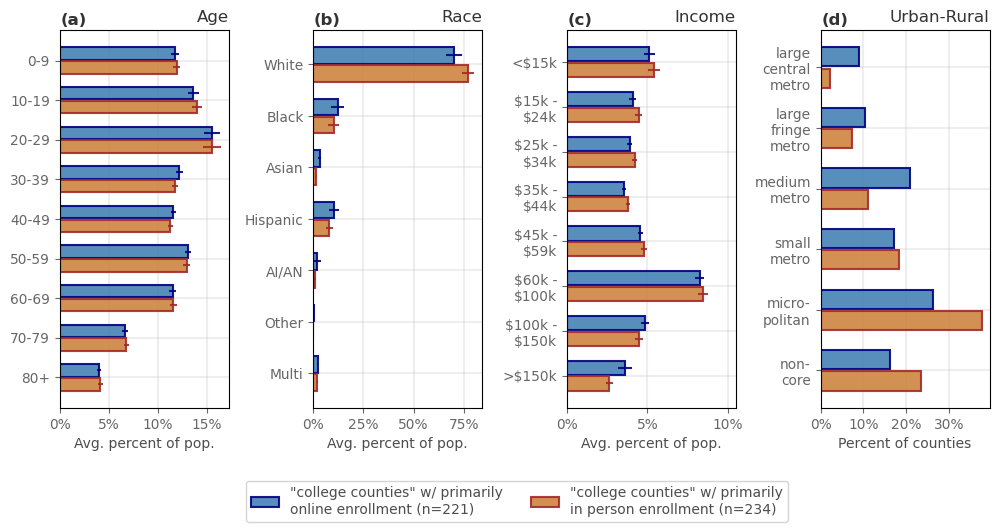

In [14]:
w = 0.35
lw = 1.5
col_e = ['navy','brown']
col_s = ['steelblue','peru']
fig, ax = plt.subplots(1,4,figsize=(12,5),dpi=100)
plt.subplots_adjust(wspace=0.5)

for i,dfi in enumerate([tmp_age_df, tmp_race_df, tmp_inc_df]):
    for xi,x in enumerate(['online','in person']):
        tmp_inc_df_i = dfi.loc[dfi['group']==x].copy()
        if i != 1:
            yv_m = ((tmp_inc_df_i['nanmean'] + tmp_inc_df_i['nanmean'].shift(-1)))[::2]
            yv_u = ((tmp_inc_df_i['ci95_hi'] + tmp_inc_df_i['ci95_hi'].shift(-1)))[::2]
            yv_l = ((tmp_inc_df_i['ci95_lo'] + tmp_inc_df_i['ci95_lo'].shift(-1)))[::2]
        else:
            yv_m = tmp_inc_df_i['nanmean']
            yv_u = tmp_inc_df_i['ci95_hi']
            yv_l = tmp_inc_df_i['ci95_lo']
        
        xv = np.linspace(0,yv_m.shape[0]-1,yv_m.shape[0])-w/2+xi*w
        if i == 2:
            ax[i].barh(xv, yv_m, height=w*0.9, ec=col_e[xi], lw=lw,
                       fc=col_s[xi], alpha=0.9, label=labs[xi])
        else:
            ax[i].barh(xv, yv_m, height=w*0.9, ec=col_e[xi], lw=lw, fc=col_s[xi], alpha=0.9)
        ax[i].hlines(xv, yv_l, yv_u, lw=lw, color=col_e[xi], alpha=0.9)
        ax[i].set_xlabel('Avg. percent of pop.', color='.3')

from collections import Counter
census_online = census_df.loc[census_df['fips'].isin(fips_online)].copy()
census_inperson = census_df.loc[census_df['fips'].isin(fips_inperson)].copy()
urc_inpers = {i:dict(Counter(census_inperson['urban_rural_code'].values))[i]/len(census_inperson) for i in range(1,7)}
urc_online = {i:dict(Counter(census_online['urban_rural_code'].values))[i]/len(census_online) for i in range(1,7)}
yv_m0 = list(urc_online.values())
yv_m1 = list(urc_inpers.values())
xv0 = np.linspace(0,len(yv_m0)-1,len(yv_m0))-w/2+0*w
xv1 = np.linspace(0,len(yv_m1)-1,len(yv_m1))-w/2+1*w
ax[-1].barh(xv0, yv_m0, height=w*0.9, ec=col_e[0], lw=lw, fc=col_s[0], alpha=0.9)
ax[-1].barh(xv1, yv_m1, height=w*0.9, ec=col_e[1], lw=lw, fc=col_s[1], alpha=0.9)
ax[-1].set_xlabel('Percent of counties', color='.3')

le = ax[2].legend(ncol=2, bbox_to_anchor=[1.35, -0.175])
for text in le.get_texts():
    text.set_color('.3')

ax[0].set_title('Age', ha='right', x=1.0, color='.2')
ax[1].set_title('Race', ha='right', x=1.0, color='.2')
ax[2].set_title('Income', ha='right', x=1.0, color='.2')
ax[3].set_title('Urban-Rural', ha='right', x=1.0, color='.2')
age_labs = ['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80+']
rac_labs = ['White','Black','Asian','Hispanic','AI/AN','Other','Multi']
inc_labs = ['<\$15k','\$15k -\n\$24k','\$25k -\n\$34k','\$35k -\n\$44k',
            '\$45k -\n\$59k','\$60k -\n\$100k','\$100k -\n\$150k','>\$150k']
urc_labs = ['large\ncentral\nmetro','large\nfringe\nmetro','medium\nmetro',
            'small\nmetro','micro-\npolitan','non-\ncore']
all_labs = [age_labs,rac_labs,inc_labs,urc_labs]
for i, l in enumerate(all_labs):
    ax[i].set_yticks(list(range(len(l))))
    ax[i].set_yticklabels(l)

letts = ["(a)","(b)",'(c)','(d)']
for ai, a in enumerate(fig.axes):
    if ai==2:
        a.set_xlim(0,.105)
    a.xaxis.set_major_formatter(mtick.PercentFormatter(1.0,decimals=0))
    a.invert_yaxis()
    a.text(0.005, 1.005, letts[ai], ha='left', va='bottom', transform=a.transAxes,
           fontweight='bold', fontsize='large', color='.2')
    a.tick_params(labelcolor='.4', color='.4',labelsize=fs*1.1)
    a.grid(linewidth=1.5, color='.75', alpha=0.25)
        
# plt.savefig('../figs/pngs/demog_compare.png', dpi=425, bbox_inches='tight')
# plt.savefig('../figs/pdfs/demog_compare.pdf', bbox_inches='tight')
plt.show()

# What about spatially?

In [15]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import geopandas as gpd

In [16]:
map_projection_init = "epsg:4269"
map_projection = "epsg:2163"

drop_list = ["72","78","69","66","60","02","15"]

gdfcounty = gpd.read_file('../../covid19-mobility/data/tl_2017_us_county/')
gdfstate = gpd.read_file('../../covid19-mobility/data/tl_2017_us_state/')
# gdfcounty = gpd.read_file('../data/tl_2017_us_county/')
# gdfstate = gpd.read_file('../data/tl_2017_us_state/')


gdfs = gdfstate.loc[~gdfstate['STATEFP'].isin(drop_list)].copy().reset_index().iloc[:,1:]
gdfc = gdfcounty.loc[~gdfcounty['STATEFP'].isin(drop_list)].copy().reset_index().iloc[:,1:]
gdfs_AL = gdfstate.loc[gdfstate['STATEFP']=='02'].copy().reset_index().iloc[:,1:]
gdfc_AL = gdfcounty.loc[gdfcounty['STATEFP']=='02'].copy().reset_index().iloc[:,1:]
gdfs_HI = gdfstate.loc[gdfstate['STATEFP']=='15'].copy().reset_index().iloc[:,1:]
gdfc_HI = gdfcounty.loc[gdfcounty['STATEFP']=='15'].copy().reset_index().iloc[:,1:]

gdfs.crs = {"init": map_projection_init}
gdfc.crs = {"init": map_projection_init}
gdfs_AL.crs = {"init": map_projection_init}
gdfc_AL.crs = {"init": map_projection_init}
gdfs_HI.crs = {"init": map_projection_init}
gdfc_HI.crs = {"init": map_projection_init}

gdfs = gdfs.to_crs({"init": map_projection})
gdfc = gdfc.to_crs({"init": map_projection})
gdfs_AL = gdfs_AL.to_crs({"init": map_projection})
gdfc_AL = gdfc_AL.to_crs({"init": map_projection})
gdfs_HI = gdfs_HI.to_crs({"init": map_projection})
gdfc_HI = gdfc_HI.to_crs({"init": map_projection})

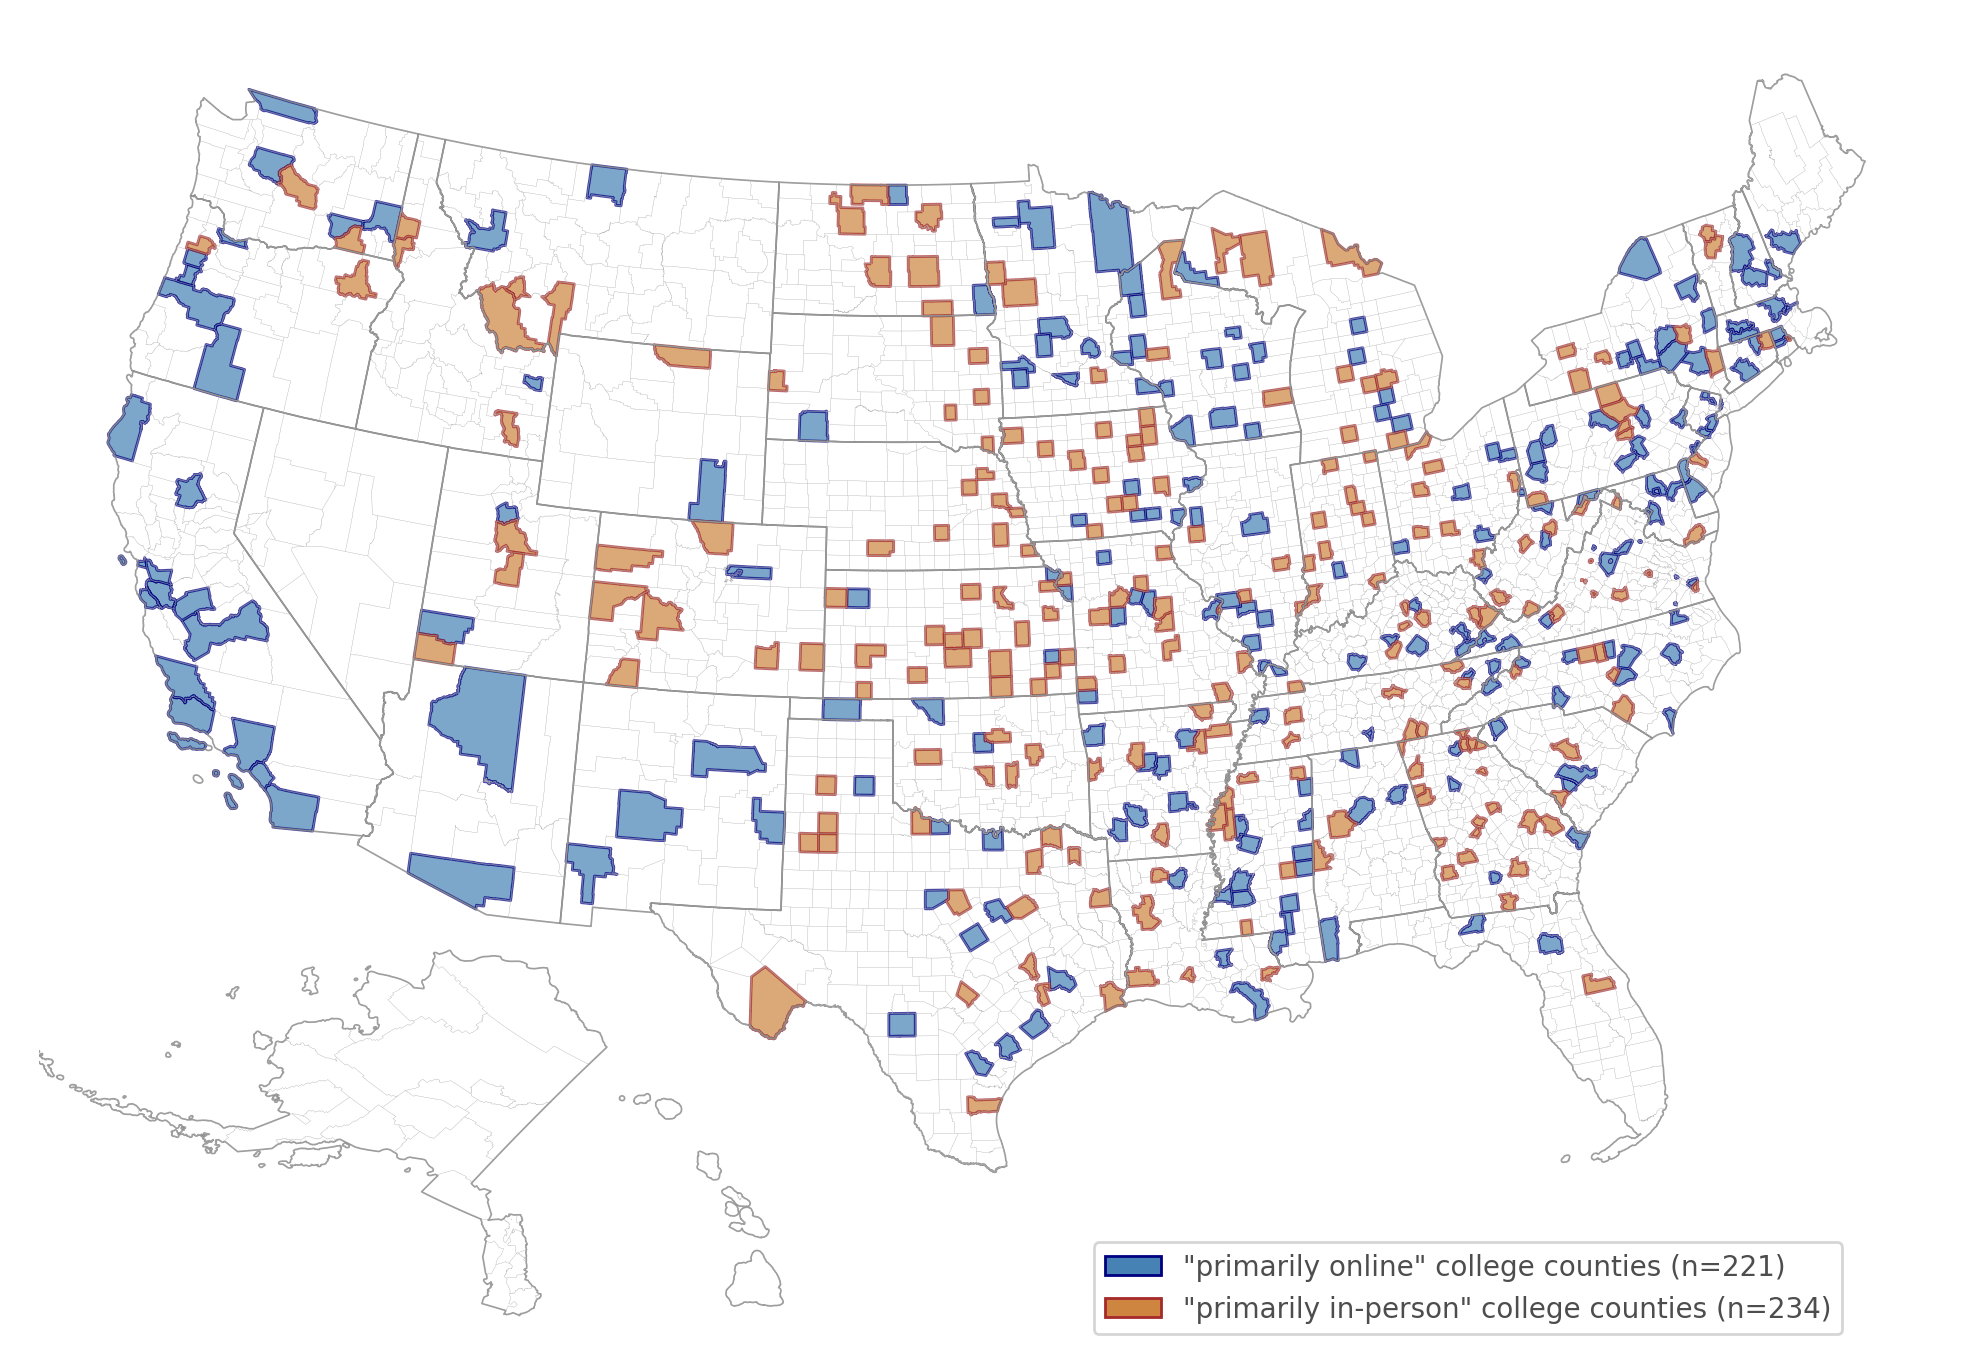

In [17]:
fig, ax = plt.subplots(1,1,figsize=(16,8),dpi=200)

m_us1 = gdfc.loc[gdfc['GEOID'].isin(fips_online)].plot(ax=ax, fc='steelblue',
                                                   ec='navy', alpha=0.7)
m_us2 = gdfc.loc[gdfc['GEOID'].isin(fips_inperson)].plot(ax=ax, fc='peru',
                                                   ec='brown', alpha=0.7)
gdfs.plot(ax=ax, lw=0.6, ec='.5', fc='none', alpha=0.8)
m_us3 = gdfc.plot(ax=ax, lw=0.1, ec='.7', fc='none', alpha=0.8)

al_ax = ax.inset_axes([0.01, -0.09, 0.30, 0.35], transform=ax.transAxes)
hi_ax = ax.inset_axes([0.25, -0.08, 0.20, 0.20], transform=ax.transAxes)

gdfs_AL.plot(ax=al_ax, lw=0.6, ec='.5', fc='none', alpha=0.8)
m_alc = gdfc_AL.plot(ax=al_ax, lw=0.1, ec='.7', fc='none', alpha=0.8)
al_xmin, al_ymin, al_xmax, al_ymax = gdfs_AL.total_bounds
al_ydiff = al_ymax-al_ymin
al_xdiff = al_xmax-al_xmin
al_ax.set_ylim(al_ymin-al_ydiff*0.02, al_ymax+al_ydiff*0.01)
al_ax.set_xlim(al_xmin+al_xdiff*0.08, al_xmax+al_xdiff*0.02)

gdfs_HI.plot(ax=hi_ax, lw=0.6, ec='.5', fc='none', alpha=0.8)
m_hic = gdfc_HI.plot(ax=hi_ax, lw=0.1, ec='.7', fc='none', alpha=0.8)
hi_xmin, hi_ymin, hi_xmax, hi_ymax = gdfs_HI.total_bounds
hi_ydiff = hi_ymax-hi_ymin
hi_xdiff = hi_xmax-hi_xmin
hi_ax.set_ylim(hi_ymin-hi_ydiff*0.02, hi_ymax-hi_ydiff*0.75)
hi_ax.set_xlim(hi_xmin+hi_xdiff*0.60, hi_xmax+hi_xdiff*0.02)

from matplotlib.patches import Patch

legend_elements = [Patch(facecolor='steelblue', edgecolor='navy',
                         label='"primarily online" college '+\
                               'counties (n=%i)'%len(fips_online)),
                   Patch(facecolor='peru', edgecolor='brown',
                         label='"primarily in-person" college '+\
                               'counties (n=%i)'%len(fips_inperson))]
ax.legend(handles=legend_elements, loc=4, bbox_to_anchor=[0.95, -0.1])
leg = ax.get_legend()
for t in leg.get_texts():
    t.set_color('.3')

for m in [m_alc,m_hic,m_us1,m_us2,m_us3]:
    m.set_rasterized(True)

ax.set_axis_off()
hi_ax.set_axis_off()
al_ax.set_axis_off()

# plt.savefig('../figs/pngs/entropy_map.png',dpi=425,bbox_inches='tight')
# plt.savefig('../figs/pdfs/entropy_map.pdf',dpi=425)#,bbox_inches='tight')

plt.show()